# Binary classification single feature

Classification using "raw" python or libraries (SciKit Learn, Tensorflow).

The classification is first on a single boundary defined by a continuous univariate function and added white noise

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as metrics
from sklearn.linear_model import LogisticRegression as SkLinReg
import scipy as sy
import seaborn as sns
import pandas

import tensorflow as tf

## Model

We want to measure or predict a value y to be above a threshold. E.g.: y is a temperature.

We know a feature x, y is related to x through a quadratic function we do not a priori know and some unknown

This unknown is modeled by a Gaussian noise

In [2]:
# Single feature, Gaussian noise
nFeatures = 1
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.2
    std = 0.2
    # Threshold from 0 to 1
    threshold = 1
    #
    x = np.random.uniform(xMin, xMax, N)
    # 4th degree relation between y and x
    yClean = 2*(x**4 + (x-0.3)**3 + b)
    labels = yClean + np.random.normal(0, std, N) > threshold
    return (x, yClean, labels)

The values of X are uniformly distributed and independent

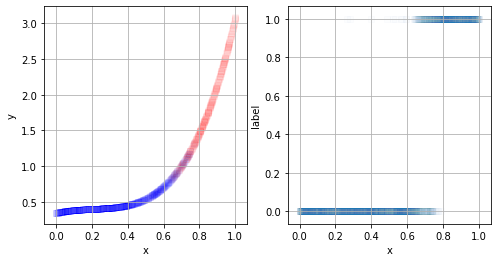

In [3]:
N = 2000
# x and y have 1 dim in R, label has 1 dim in B
xTrain, yCleanTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(xTrain, yCleanTrain, c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.01)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(1,2,2)
plt.scatter(xTrain, labelTrain, marker=',', alpha=0.01)
plt.xlabel('x')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.3005


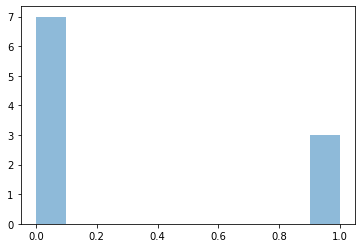

In [4]:
count, bins, ignored = plt.hist(labelTrain*1.0, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

Note: The two values are not a priori equi probable. In theory, ressampling of the training values would be required to balance the a priori distribution.

In [5]:
xTest, yTest, labelTest = generateBatch(N)

## Helpers

In [6]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

### Logistic and log of Logistic functions

In [7]:
def logistic(X):
    return (1+(np.exp(-(X))))**-1

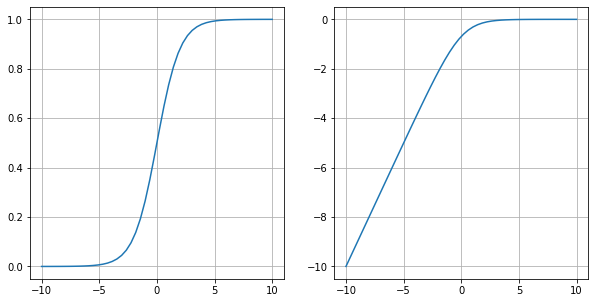

In [8]:
xx = np.linspace(-10, 10)
xlogistic = logistic(xx)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(xx, xlogistic)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(xx, np.log(xlogistic))
plt.grid()

# Logistic regression

\begin{align}
y \in \left\{ 0, 1 \right\}
\end{align}

\begin{align}
p(Y=1 \mid x) & = \frac{1}{1+e^{-f_\theta(x)}} \\
f_\theta(x) & = b + w x \\
\theta &= \{b, w\}
\end{align}

We are looking for the value of w that maximize the likelyhood:
\begin{align}
\hat{\theta} & = \max_{\theta}{\prod_{i=0}^N{p(y_i \mid  x_i, w)}} \\
& = \max_{\theta}{\sum_{i=0}^N{log \left(p(y_i \mid x_i, w)\right)} } \\
& = \max_{\theta}{\sum_{i=0}^N{log \left(\left(\frac{1}{1+e^{-f_\theta(x_i)}}\right)^{y_i}\left(1-\frac{1}{1+e^{-f_\theta(x_i)}}\right)^{1-y_i}\right)} } \\
& = \max_{\theta}{\sum_{i=0}^N{log \left(y_i * \left(\frac{1}{1+e^{-f_\theta(x_i)}}\right) + \left(1-y_i\right) * \left(1-\frac{1}{1+e^{-f_\theta(x_I)}}\right) \right)} } \\
\end{align}

Using the fact that $y_i$ is either 0 or 1. The last formulation is avoiding logarithm of zero as one of the two terms within the sum is null.

Since the number of classes is 2, the maximum log likelyhood is also called binary cross entropy.

Reference:
- https://en.wikipedia.org/wiki/Logistic_regression


## Fitting of $b$ and then $w$


Suboptimal fitting:
- Taking some assumption on $w$ to fit $b$ as $\hat{b}$
- and then fitting $w$ with the $\hat{b}$ estimate

Estimate b = -1.3265306122448979


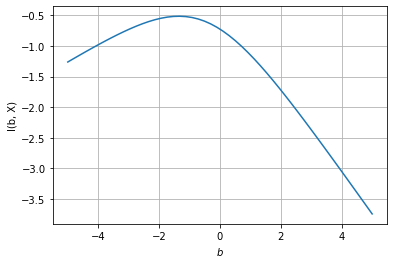

In [9]:
b = np.linspace(-5, 5)
w = 1
px = np.zeros(len(b))
for i in range(len(b)):
    fx = logistic(b[i] + w*xTrain)
    px[i] = 1/N * np.sum(np.log(labelTrain*fx + (1-labelTrain)*(1-fx)))
plt.plot(b, px);
plt.xlabel('$b$')
plt.ylabel('l(b, X)')
plt.grid()
bHat = b[np.argmax(px)]
print('Estimate b =', bHat) 

Estimate w = 2.0408163265306136


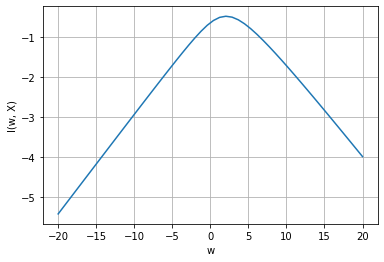

In [10]:
w = np.linspace(-20, 20)
px = np.zeros(len(w))
for i in range(len(w)):
    fx = logistic(bHat + w[i]*xTrain)
    px[i] = 1/N * np.sum(np.log(labelTrain*fx + (1-labelTrain)*(1-fx)))
plt.plot(w, px);
plt.xlabel('w')
plt.ylabel('l(w, X)')
plt.grid()
wHat = w[np.argmax(px)]
print('Estimate w =', wHat)

In [11]:
pXTest0 = logistic(bHat + wHat * xTest)
labelEst0 = pXTest0 > 0.5

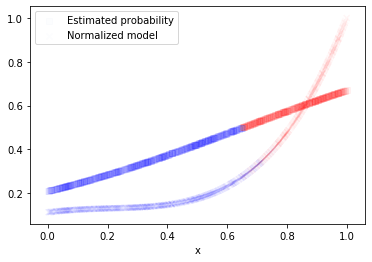

In [12]:
plt.scatter(xTest, pXTest0, c=labelEst0, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.01);
plt.scatter(xTest, yTest/np.max(yTest), c = labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.01);
plt.xlabel('x')
plt.legend(('Estimated probability', 'Normalized model'));

Bernouilli parameter = 0.368


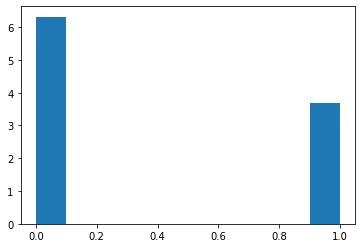

In [13]:
plt.hist(labelEst0*1.0, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst0))

In [14]:
accuracy0 = np.sum(labelTest == labelEst0)/N
print('Accuracy =', accuracy0)

Accuracy = 0.9315


### Precision 
$p(y = 1 \mid \hat{y} = 1)$

In [15]:
print('Precision =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelEst0))

Precision = 0.8383152173913043


### Recall
$p(\hat{y} = 1 \mid y = 1)$

In [16]:
print('Recall =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelTest))

Recall = 0.9716535433070866


### Confusion matrix

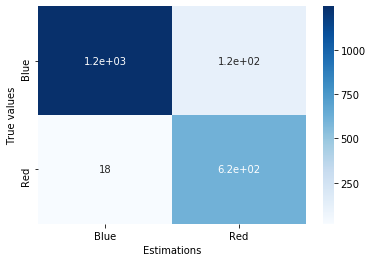

In [17]:
plotConfusionMatrix(labelTest, labelEst0, np.array(['Blue', 'Red']));

In [18]:
print(metrics.classification_report(labelTest, labelEst0))

              precision    recall  f1-score   support

       False       0.99      0.91      0.95      1365
        True       0.84      0.97      0.90       635

    accuracy                           0.93      2000
   macro avg       0.91      0.94      0.92      2000
weighted avg       0.94      0.93      0.93      2000



# SciKit Learn

References:
- SciKit documentation
- https://www.geeksforgeeks.org/ml-logistic-regression-using-python/

In [19]:
model1 = SkLinReg(solver='lbfgs')
model1.fit(xTrain.reshape(-1,1), labelTrain)
model1.coef_

array([[13.08470501]])

In [20]:
labelEst1 = model1.predict(xTest.reshape(-1,1))
print('Accuracy =',model1.score(xTest.reshape(-1,1), labelTest))

Accuracy = 0.948


Bernouilli parameter = 0.3225


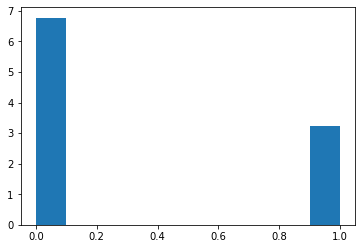

In [21]:
plt.hist(labelEst1*1.0, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst1))

### Confusion matrix (plot)

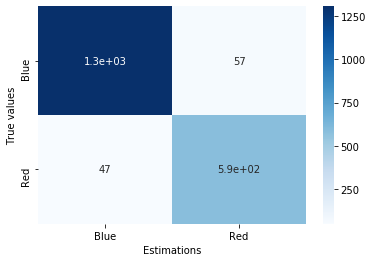

In [22]:
plotConfusionMatrix(labelTest, labelEst1, np.array(['Blue', 'Red']))

### Classification report

In [23]:
print(metrics.classification_report(labelTest, labelEst1))

              precision    recall  f1-score   support

       False       0.97      0.96      0.96      1365
        True       0.91      0.93      0.92       635

    accuracy                           0.95      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.95      0.95      2000



References :
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.get_params

### ROC curve

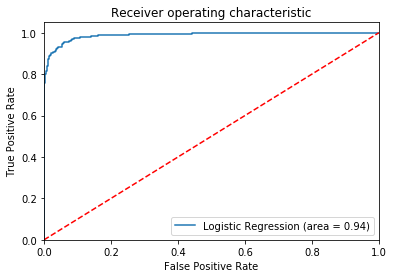

In [24]:
logit_roc_auc = metrics.roc_auc_score(labelTest, labelEst1)
fpr, tpr, thresholds = metrics.roc_curve(labelTest, model1.predict_proba(xTest.reshape(-1,1))[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

# Using TensorFlow 2.0

In TensorFlow 2.0 many possibilities are available to design a sequential layer. It could be based on high level API using Keras, down to function code close to the syntax of Tensorflow 1.0. 

Following design is showing how to implement a custom layer within a Sequential pipeline of Keras, and how to implement a custom metric. This is the favoured method to implement custom code in TensorFlow 2.0.

In [25]:
# Labels as floats {0., 1.}
labelTrainF = np.multiply(labelTrain, 1.0)
labelTrainF.dtype, labelTrainF.shape

(dtype('float64'), (2000,))

In [26]:
# (Mini) Batch size
nBatch = 100
# Number of batches per Epoch
nBatchPerEpoch =20
# Number of epochs
nEpochMax = 1000

In [27]:
# Simple custom layer exposing the linear regression model
class MyLogisticRegressionLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(MyLogisticRegressionLayer, self).__init__(*args, **kwargs)
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=input_shape[0],
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)
        self.b = self.add_weight(
            shape=1,
            dtype=self.dtype,
            initializer=tf.keras.initializers.ones(),
            #regularizer=tf.keras.regularizers.l2(0.02),
            trainable=True)

    @tf.function
    def call(self, x, training=None):
        return tf.math.sigmoid(tf.math.add(tf.math.multiply(x, self.w), self.b))

In [28]:
# Using TensorFlow 2.0 style of metrics to implement accuracy
class MyBinaryAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name='my_accuracy', **kwargs):
        super(MyBinaryAccuracy, self).__init__(name=name, **kwargs)
        self.accuracySum = self.add_weight(name='accuracySum', 
                                           initializer='zeros')
        self.accuracyCount = self.add_weight(name='accuracyCount', 
                                             initializer='zeros')

    def update_state(self, labels, yEst):
        labels = tf.cast(labels, tf.bool)
        labelEst = tf.greater(yEst, 0.5)

        values = tf.cast(tf.equal(labels, labelEst), self.dtype)
        self.accuracySum.assign_add(tf.reduce_sum(values))
        self.accuracyCount.assign_add(values.get_shape()[0])

    def result(self):
        return self.accuracySum / self.accuracyCount

In [29]:
# Model 1, instantiate the custom layer
model1 = tf.keras.Sequential([MyLogisticRegressionLayer(input_shape=[nFeatures], dtype="float64")])

# Stochastic Gradient Descent Optimizer
optim1 = tf.keras.optimizers.SGD(0.01)

# Perform a train step on a mini-batch
#  This function's code is rewritten by TensorFlow 2.0 and shall be compiled at every execution of the optimizer
@tf.function
def trainStep1(x, labels):
    with tf.GradientTape() as tape:
        predictions = model1(x, training=True)
        loss = -tf.reduce_sum(tf.math.log((labels * predictions) + ((1 - labels) * (1 - predictions))))
        #loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
        
        gradients = tape.gradient(loss, model1.trainable_variables)
        optim1.apply_gradients(zip(gradients, model1.trainable_variables))
        return loss, predictions
    
# Initialize values and loop on epochs and mini batch
epoch = 0
cost_epoch = 1
histo = []
accuracy = MyBinaryAccuracy()
for epoch in range(nEpochMax):
    cost_cumul = 0
    accuracy.reset_states()
    for b in range(0, nBatchPerEpoch*nBatch, nBatch):  
        cost, predictions = trainStep1(xTrain[b : b + nBatch], labelTrainF[b : b + nBatch])
        cost_cumul += cost
        accuracy.update_state(labelTrainF[b : b + nBatch], predictions)
        
    cost_epoch = cost_cumul / nBatchPerEpoch
    W = model1.get_weights()
    histo.append((cost_epoch.numpy(), accuracy.result().numpy(), W[1][0], W[0]))

print("Predicted model: {b:.3f} + {w:.3f} x, num epochs={c}".format(w=W[0], b=W[1][0], c=len(histo)))

# Save history as a Panda Data Frame
df = pandas.DataFrame(histo, columns = ('cost', 'accuracy', 'b', 'w0'))

Predicted model: -17.421 + 25.190 x, num epochs=1000


SGD shows that there is not a single optimal value for b+w (intercept + slope) but a straight line  as shown on the graph below.
This is explained by the single feature: the decision boundary does not need to be a straight line, a single intercept point would be enough.

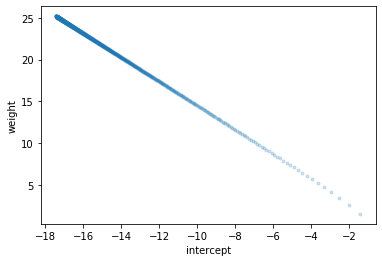

In [30]:
plt.scatter(df['b'], df['w0'], marker='.', alpha=0.2);
plt.xlabel('intercept')
plt.ylabel('weight');

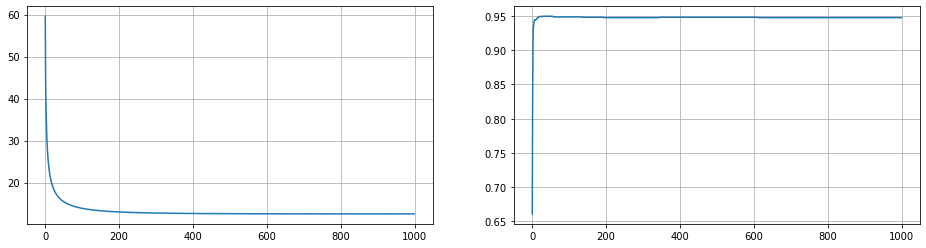

In [31]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
ax[0].plot(df['cost'])
ax[0].grid()
ax[1].plot(df['accuracy'])
ax[1].grid()

# Where to go from here ?

__More complex models__ with the 2 feature [binary classification](ClassificationContinuous2Features.html) ([Notebook](ClassificationContinuous2Features.ipynb)) or the [K Nearest Neighbors classifier](ClassificationContinuous2Features-KNN.html) ([Notebook](ClassificationContinuous2Features-KNN.ipynb))

__Compare with the single feature linear regression__ [using simple algorithms](../linear/LinearRegressionUnivariate.html) ([Notebook](LinearRegressionUnivariate.ipynb])), [or using Tensorflow](LinearRegressionUnivariate-TensorFlow.html) ([Notebook](LinearRegressionUnivariate-TensorFlow.ipynb))